In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

2024-04-23 18:26:32.112281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.16.1


## Data Preprocessing

In [3]:
DATASET = "./Parking_Data.csv"

In [10]:
dataframe = pd.read_csv(DATASET, delimiter=',')
dataframe.head()

,Bldg City,Bldg State,Bldg Status,Property Type,Total Parking Spaces,Owned/Leased
0,HARTFORD,CT,ACTIVE,BUILDING,29,OWNED
1,NEW HAVEN,CT,ACTIVE,BUILDING,0,OWNED
2,WATERBURY,CT,ACTIVE,BUILDING,2,LEASED
3,WILLIMANTIC,CT,ACTIVE,BUILDING,0,LEASED
4,HARTFORD,CT,ACTIVE,BUILDING,103,OWNED


In [11]:
print(dataframe.size)

54360


In [7]:
print(dataframe['Bldg City'].unique())
print(len(dataframe['Bldg City'].unique()))

['HARTFORD' 'NEW HAVEN' 'WATERBURY' ... 'STATELINE' 'PAHRUMP' 'FALLON']
1900


In [12]:
top_cities = dataframe['Bldg City'].value_counts().head(6)
top_cities


Bldg City
WASHINGTON     487
EL PASO         89
LAREDO          81
SPRINGFIELD     79
LAKEWOOD        79
ARLINGTON       78
Name: count, dtype: int64

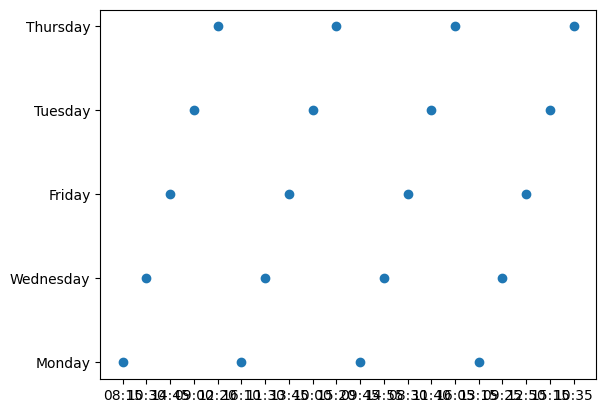

In [44]:
def plot_spot_time(dataframe):
    plt.scatter(dataframe['TIME'], dataframe['DAY'])
    plt.show()

plot_spot_time(dataframe)

In [47]:
def one_hot(dataframe):
    dataframe = pd.get_dummies(dataframe, columns=['PLACE'],dtype=np.int64)
    dataframe.head()
    dataframe = pd.get_dummies(dataframe, columns=['DAY'],dtype=np.int64)
    dataframe.head()
    return dataframe

def time_to_minutes(dataframe):
    dataframe['TIME'] = pd.to_datetime(dataframe['TIME'])
    dataframe['TIME'] = dataframe['TIME'].dt.hour * 60 + dataframe['TIME'].dt.minute
    return dataframe

def normalize_time(dataframe):
    dataframe['TIME'] = (dataframe['TIME'] - dataframe['TIME'].min()) / (dataframe['TIME'].max() - dataframe['TIME'].min())
    return dataframe

time_to_minutes(one_hot(dataframe)).head()

/tmp/ipykernel_123126/3527264992.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['TIME'] = pd.to_datetime(dataframe['TIME'])


,TIME,OCCUPANCY,PLACE_Spot A,PLACE_Spot B,PLACE_Spot C,PLACE_Spot D,DAY_Friday,DAY_Monday,DAY_Thursday,DAY_Tuesday,DAY_Wednesday
0,495,3,1,0,0,0,0,1,0,0,0
1,630,1,0,1,0,0,0,0,0,0,1
2,885,5,0,0,1,0,1,0,0,0,0
3,540,2,0,0,0,1,0,0,0,1,0
4,740,4,1,0,0,0,0,0,1,0,0


In [48]:
def get_test_train_data(dataframe):
    dataframe = time_to_minutes(one_hot(dataframe))
    dataframe = normalize_time(dataframe)
    dataframe = dataframe.sample(frac=1)
    dataframe.head()
    train_size = int(len(dataframe) * 0.8)
    train = dataframe[:train_size]
    test = dataframe[train_size:]
    return train, test

def get_x_y(dataframe):
    y = dataframe['OCCUPANCY']
    x = dataframe.drop(columns=['OCCUPANCY'])
    return x, y

def convert_to_numpy(x, y):
    x = np.array(x)
    y = np.array(y)
    return x, y

In [49]:
train, test = get_test_train_data(dataframe)

x_train, y_train = get_x_y(train)
x_test, y_test = get_x_y(test)

x_train, y_train = convert_to_numpy(x_train, y_train)
x_test, y_test = convert_to_numpy(x_test, y_test)

/tmp/ipykernel_123126/3527264992.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataframe['TIME'] = pd.to_datetime(dataframe['TIME'])


In [50]:
x_train

array([[0.41052632, 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.57894737, 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.18947368, 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.43157895, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.03157895, 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.98947368, 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.29473684, 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.       

In [51]:
y_train

array([6, 4, 4, 3, 6, 1, 3, 3, 3, 0, 1, 1, 2, 2, 0, 0])

In [52]:
xDims = x_train.shape
yDims = y_train.shape

print("xDims: ", xDims)
print("yDims: ", yDims)

xDims:  (16, 10)
yDims:  (16,)


In [59]:
def createModel():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(128, input_shape=(xDims[1],), activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error', metrics=['accuracy'])
    return model

model = createModel()

model.summary()

/home/geoffrey/Documents/clg/embedded-project/ml/venv-ml/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,993 (66.38 KB)

 Trainable params: 16,993 (66.38 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(x_train, y_train, epochs=500)

Epoch 1/500


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1875 - loss: 2.4027
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1250 - loss: 2.0574
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1875 - loss: 1.6052
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1875 - loss: 2.2500
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1875 - loss: 1.3857
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1875 - loss: 1.3456
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1875 - loss: 1.4161
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1875 - loss: 1.3825
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 1.1535
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1875 - loss: 0.8354
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1875 - loss: 0.8411
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2500 - loss: 0.9335
Epo

In [61]:
model.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.0000e+00 - loss: 1.7568


[1.7567987442016602, 0.0]

In [62]:
pred = model.predict(x_train)
print(pred)
print(y_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[6.1096587]
 [4.2691236]
 [4.131404 ]
 [3.1971536]
 [6.2780747]
 [1.0016922]
 [3.1473901]
 [2.9385319]
 [3.127843 ]
 [0.       ]
 [1.0320877]
 [1.0344139]
 [2.0228183]
 [2.08621  ]
 [0.       ]
 [0.       ]]
[6 4 4 3 6 1 3 3 3 0 1 1 2 2 0 0]
